In [ ]:
# Install The Tools

In [2]:
!pip install -q --no-cache-dir albumentations==1.3.1
!pip install -q --no-cache-dir albucore==0.0.12

# Distribution Matching MCNN

## Getting data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tthien/shanghaitech")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'shanghaitech' dataset.
Path to dataset files: /kaggle/input/shanghaitech


## Saving

In [7]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define your save path on Drive
# Feel free to change 'DIP_Crowd_Counting' to your preferred folder name
drive_root = '/content/drive/MyDrive/DIP_Crowd_Counting'
checkpoint_dir = os.path.join(drive_root, 'checkpoints')

# 3. Create the folder if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Created new directory on Drive: {checkpoint_dir}")
else:
    print(f"Found existing directory on Drive: {checkpoint_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found existing directory on Drive: /content/drive/MyDrive/DIP_Crowd_Counting/checkpoints


## Loss Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io as io
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import random

In [4]:
# --- 1. OT Loss Implementation (Sinkhorn Algorithm) ---
class DMCountLoss(nn.Module):
    def __init__(self, use_background=False, device='cuda'):
        super(DMCountLoss, self).__init__()
        self.device = device

    def forward(self, pred_density, points):
        """
        pred_density: (1, 1, H, W) - Predicted density map (must be positive)
        points: (1, N, 2) - Tensor containing N points (x, y)
        """
        # 1. Counting Loss (L1)
        # Sum of density map should equal number of points
        gt_count = points.shape[1]
        pred_count = pred_density.sum()
        count_loss = torch.abs(pred_count - gt_count)

        # 2. Optimal Transport (OT) Loss
        # We need to reshape density to (H*W) and normalize to sum to 1
        b, c, h, w = pred_density.shape
        pred_norm = pred_density / (pred_count + 1e-6) # Normalize to PDF

        # Coordinate grid generation for the density map
        # Generates (x,y) coordinates for every pixel in the HxW map
        y_coords, x_coords = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
        coords = torch.stack([x_coords, y_coords], dim=2).float().to(self.device) # (H, W, 2)
        coords = coords.view(-1, 2) # (H*W, 2) Flattened pixel coords

        pred_vec = pred_norm.view(-1) # (H*W) Flattened probability vector

        # Ground Truth distribution is just uniform weight on the points
        # Each point has weight 1/N
        target_vec = torch.ones(gt_count).to(self.device) / gt_count

        # Calculate Cost Matrix (Distance between every pixel and every GT point)
        # Using L2 distance squared
        # coords: (M, 2), points: (N, 2) -> Cost: (M, N)
        # Note: For very large images, this matrix can be memory heavy.
        # Standard DM-Count often creates a "target density" or uses Sinkhorn approx.
        # Here we use a simplified approximate matching if N is small, or just Count Loss if N=0.

        ot_loss = 0.0
        if gt_count > 0:
            # We use the 'geomloss' logic simplified:
            # Calculate distance from every pixel to nearest point
            # For exact OT, we need the Sinkhorn iteration.
            # To keep it runnable in standard Colab without C++ extensions,
            # we will use a "Dot Regression" proxy often used in DM-Count simplified versions:
            # However, below is a basic Sinkhorn step if you want exactness:

            # Simplified Cost: sum(pred_prob_i * min_dist_i_to_any_gt)
            # This is a "Unbalanced" approximation often used when full OT is too slow
            dists = torch.cdist(coords, points.squeeze(0)) # (H*W, N)

            # Find closest GT point for every pixel (rough assignment)
            min_dists, _ = torch.min(dists, dim=1) # (H*W)

            # Weighted sum of distances
            ot_loss = torch.sum(pred_vec * (min_dists * min_dists)) * 0.01 # Scale factor

        # 3. Total Variation Loss (Smoothness)
        # Enforces that neighboring pixels have similar values
        diff1 = torch.abs(pred_density[:, :, :, :-1] - pred_density[:, :, :, 1:])
        diff2 = torch.abs(pred_density[:, :, :-1, :] - pred_density[:, :, 1:, :])
        tv_loss = (torch.sum(diff1) + torch.sum(diff2)) * 0.01

        return count_loss + ot_loss + tv_loss

## DataLoader

In [5]:
!pip install -q --no-cache-dir opencv-python==4.5.5.64
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CrowdDatasetAugmented(Dataset):
    def __init__(self, img_root, gt_mat_root, phase='train', gt_downsample=4, train_ratio=0.9):
        self.img_root = img_root
        self.gt_mat_root = gt_mat_root
        self.gt_downsample = gt_downsample
        self.phase = phase.lower()
        self.train_ratio = train_ratio  # ← 一定要加這個參數！

        # 讀所有圖片名稱
        all_names = [f for f in os.listdir(img_root) if f.endswith('.jpg')]
        all_names.sort()

        # 固定 seed + 打亂 + 切分
        import random
        random.seed(42)
        random.shuffle(all_names)

        split_idx = int(len(all_names) * train_ratio)

        if self.phase == 'train':
            self.img_names = all_names[:split_idx]
        else:  # 'val' or 'test'
            self.img_names = all_names[split_idx:]

        print(f"[{self.phase.upper()}] Loaded {len(self.img_names)} images")

        # ==================== 超強增強管線（跟之前一樣）===================
        if self.phase == 'train':
            self.transform = A.Compose([
                A.RandomScale(scale_limit=(0.6, 2.5), p=1.0),
                A.Resize(512, 512),  # 強制變 512，永遠不會爆
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.8),
                A.OneOf([A.GaussNoise(), A.ISONoise(), A.ImageCompression(quality_lower=70)], p=0.5),
                A.CoarseDropout(max_holes=20, max_height=64, max_width=64, p=0.6),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        else:
            self.transform = A.Compose([
                A.Resize(512, 512),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img_path = os.path.join(self.img_root, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 讀取點
        mat_name = "GT_" + img_name.replace('.jpg', '.mat')
        mat_path = os.path.join(self.gt_mat_root, mat_name)
        points = []
        if os.path.exists(mat_path):
            mat = io.loadmat(mat_path)
            points = mat["image_info"][0,0][0,0][0]   # (N, 2)

        # Albumentations 需要 keypoint 格式
        keypoints = [(float(p[0]), float(p[1])) for p in points]

        # 套用增強（圖片 + 點會自動同步變換）
        augmented = self.transform(image=img, keypoints=keypoints)
        img_aug = augmented['image']                    # (3, H, W) tensor
        keypoints_aug = augmented['keypoints']          # list of (x,y)

        # 點要除以 downsample（因為模型輸出是 1/4）
        keypoints_aug = np.array(keypoints_aug) / self.gt_downsample

        points_tensor = torch.from_numpy(keypoints_aug).float()

        return img_aug, points_tensor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 141.3 MB/s eta 0:00:00


## Model

In [17]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class MCNN_DM(nn.Module):
    def __init__(self):
        super(MCNN_DM, self).__init__()

        # Branch 1 (Large)
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 16, 9, padding=4), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding=3), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 7, padding=3), nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, 7, padding=3), nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5)
        )
        # Branch 2 (Medium)
        self.branch2 = nn.Sequential(
            nn.Conv2d(3, 20, 7, padding=3), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(40, 20, 5, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(20, 10, 5, padding=2), nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5)
        )
        # Branch 3 (Small)
        self.branch3 = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(48, 24, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(24, 12, 3, padding=1), nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5)
        )
        self.attention = SEBlock(30)  # In front of fuse


        self.fuse = nn.Conv2d(30, 1, 1, padding=0)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None: nn.init.constant_(m.bias, 0)

    def forward(self, x):
      x1 = self.branch1(x)
      x2 = self.branch2(x)
      x3 = self.branch3(x)
      x = torch.cat((x1, x2, x3), 1)
      x = self.attention(x)  # Adds attentions
      x = self.fuse(x)
      x = F.relu(x)
      return x

In [18]:

import pandas as pd
import torch
from torch.utils.data import DataLoader

# Paths
full_train_img_root = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images'
full_train_gt_root  = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth'

# 直接讓 Dataset 自己內部切分（我在 class 裡面加一個比例參數）
# → 改寫 CrowdDatasetAugmented 支援 train/val split

# 直接這樣寫（最乾淨！）
train_dataset = CrowdDatasetAugmented(full_train_img_root, full_train_gt_root,
                                      phase='train', gt_downsample=4, train_ratio=0.9)  # 我幫你加這個參數
val_dataset   = CrowdDatasetAugmented(full_train_img_root, full_train_gt_root,
                                      phase='val',   gt_downsample=4, train_ratio=0.9)

print(f"Training Set: {len(train_dataset)} images")
print(f"Validation Set: {len(val_dataset)} images")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

[TRAIN] Loaded 270 images
[VAL] Loaded 30 images
Training Set: 270 images
Validation Set: 30 images


## Train (Sched)

In [22]:
import torch.optim as optim


model_name = "Scheduler"
epochs = 800
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output Paths (Google Drive)
drive_save_dir = '/content/drive/MyDrive/DIP_Crowd_Counting'
csv_path = os.path.join(drive_save_dir, 'training_log.csv')

# Initialize Model & Optimizer
model = MCNN_DM().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=20
)

criterion = DMCountLoss(device=device)

# Initialize DataFrame
# We check if a log already exists to avoid overwriting if you restart
history_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_mae', 'train_mse',
                                   'val_loss', 'val_mae', 'val_mse'])

min_val_mae = float('inf') # Track best validation score

print("Starting Training with Validation Tracking...")

for epoch in range(epochs):
    # --- 1. TRAINING PHASE ---
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    train_mse = 0.0

    for img, points in train_loader:
        img = img.to(device)
        points = points.to(device)

        # Forward
        pred_dmap = model(img)
        loss = criterion(pred_dmap, points)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Professor's Tip: Gradient Clipping is often helpful in crowd counting
        # to prevent exploding gradients in dense regions.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

        optimizer.step()

        # Metrics
        iter_loss = loss.item()
        pred_count = pred_dmap.sum().item()
        gt_count = points.shape[1]

        train_loss += iter_loss
        train_mae += abs(pred_count - gt_count)
        train_mse += (pred_count - gt_count) ** 2

    # Averages
    avg_train_loss = train_loss / len(train_loader)
    avg_train_mae = train_mae / len(train_loader)
    avg_train_mse = (train_mse / len(train_loader)) ** 0.5

    # --- 2. VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    val_mse = 0.0

    with torch.no_grad():
        for img, points in val_loader:
            img = img.to(device)
            points = points.to(device)

            pred_dmap = model(img)
            # CRITICAL: We need the validation loss for the scheduler!
            loss = criterion(pred_dmap, points)

            val_loss += loss.item()
            pred_count = pred_dmap.sum().item()
            gt_count = points.shape[1]

            val_mae += abs(pred_count - gt_count)
            val_mse += (pred_count - gt_count) ** 2

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mae = val_mae / len(val_loader)
    avg_val_mse = (val_mse / len(val_loader)) ** 0.5

    # --- 3. SCHEDULER STEP (THE FIX) ---
    # This checks if avg_val_loss has improved. If not for 'patience' epochs, it lowers LR.
    scheduler.step(avg_val_loss)
    #scheduler.step()

    # Get current LR for logging
    current_lr = optimizer.param_groups[0]['lr']

    # --- 4. LOGGING ---
    print(f"Epoch {epoch:03d} | LR: {current_lr:.2e} | "
          f"Train Loss: {avg_train_loss:.4f} MAE: {avg_train_mae:.1f} | "
          f"Val Loss: {avg_val_loss:.4f} MAE: {avg_val_mae:.1f}")

    new_row = {
        'epoch': epoch,
        'lr': current_lr, # Log LR to debug
        'train_loss': avg_train_loss, 'train_mae': avg_train_mae, 'train_mse': avg_train_mse,
        'val_loss': avg_val_loss, 'val_mae': avg_val_mae, 'val_mse': avg_val_mse
    }
    history_df = pd.concat([history_df, pd.DataFrame([new_row])], ignore_index=True)
    history_df.to_csv(csv_path, index=False)

    # Save Best Model
    # Using MAE is better than Loss for model selection in this task
    if avg_val_mae < min_val_mae:
        min_val_mae = avg_val_mae
        best_path = os.path.join(drive_save_dir, f"model_{model_name}.pth")
        torch.save(model.state_dict(), best_path)
        print(f"    >>> New Best Val MAE: {min_val_mae:.2f}. Saved.")

print("Training Finished.")

Starting Training with Validation Tracking...
Epoch 000 | LR: 1.00e-04 | Train Loss: 440.5165 MAE: 440.5 | Val Loss: 652.1667 MAE: 652.2
    >>> New Best Val MAE: 652.17. Saved.


/tmp/ipython-input-3874554023.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history_df = pd.concat([history_df, pd.DataFrame([new_row])], ignore_index=True)


Epoch 001 | LR: 1.00e-04 | Train Loss: 430.6519 MAE: 430.7 | Val Loss: 652.1667 MAE: 652.2
Epoch 002 | LR: 1.00e-04 | Train Loss: 446.0556 MAE: 446.1 | Val Loss: 652.1667 MAE: 652.2
Epoch 003 | LR: 1.00e-04 | Train Loss: 440.1556 MAE: 440.2 | Val Loss: 652.1667 MAE: 652.2
Epoch 004 | LR: 1.00e-04 | Train Loss: 441.8926 MAE: 441.9 | Val Loss: 652.1667 MAE: 652.2


KeyboardInterrupt: 

## Training on the DilatedCC


In [28]:
import torch
import torch.nn as nn
from torchvision import models

# -----------------
# 1. 定義改進後的模型類 (DilatedCrowdCounter)
# -----------------

class DilatedCrowdCounter(nn.Module):
    """
    基於 VGG-16 和空洞卷積的單一分支人群計數模型 (類似 CSRNet)
    """
    def __init__(self, load_weights=False):
        super(DilatedCrowdCounter, self).__init__()

        # 1.1 VGG-16 主幹網絡 (Frontend)
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(vgg.features)[:23])

        # 1.2 空洞卷積後端 (Backend) - in_channels=512
        self.backend = make_dilated_backend_with_dropout(in_channels=512)

        # 1.3 最終輸出層 - 期望 512 個輸入通道
        self.output_layer = nn.Conv2d(512, 1, kernel_size=1) # <--- 期望 512

        if not load_weights:
            self._initialize_weights()

    def forward(self, img_tensor):
        x = self.frontend(img_tensor)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        nn.init.normal_(self.output_layer.weight, std=0.01)
        nn.init.constant_(self.output_layer.bias, 0)


# ----------------------------------------------------
# 2. 定義加入 Dropout 的空洞卷積後端構造函數 (已修正通道數)
# ----------------------------------------------------

def make_dilated_backend_with_dropout(in_channels, dropout_rate=0.5):
    """
    創建一個包含多層空洞卷積和 Dropout 的後端網絡
    """
    # 修正: 將最後一個通道數 256 改為 512，確保輸出通道數為 512，匹配 output_layer
    cfg = [(512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2)]

    layers = []

    for v, k, d in cfg:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=k, padding=d, dilation=d)
        layers += [
            conv2d,
            nn.ReLU(inplace=True),
            # NEW: 在 ReLU 之後加入 Dropout 層
            nn.Dropout2d(p=dropout_rate)
        ]
        in_channels = v

    return nn.Sequential(*layers)

In [29]:
import torch.optim as optim


model_name = "Dilatedvgg16"
epochs = 800
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output Paths (Google Drive)
drive_save_dir = '/content/drive/MyDrive/DIP_Crowd_Counting'
csv_path = os.path.join(drive_save_dir, 'training_log.csv')

# Initialize Model & Optimizer
model =  DilatedCrowdCounter().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=20
)

criterion = DMCountLoss(device=device)

# Initialize DataFrame
# We check if a log already exists to avoid overwriting if you restart
history_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_mae', 'train_mse',
                                   'val_loss', 'val_mae', 'val_mse'])

min_val_mae = float('inf') # Track best validation score

print("Starting Training with Validation Tracking...")

for epoch in range(epochs):
    # --- 1. TRAINING PHASE ---
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    train_mse = 0.0

    for img, points in train_loader:
        img = img.to(device)
        points = points.to(device)

        # Forward
        pred_dmap = model(img)
        loss = criterion(pred_dmap, points)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Professor's Tip: Gradient Clipping is often helpful in crowd counting
        # to prevent exploding gradients in dense regions.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

        optimizer.step()

        # Metrics
        iter_loss = loss.item()
        pred_count = pred_dmap.sum().item()
        gt_count = points.shape[1]

        train_loss += iter_loss
        train_mae += abs(pred_count - gt_count)
        train_mse += (pred_count - gt_count) ** 2

    # Averages
    avg_train_loss = train_loss / len(train_loader)
    avg_train_mae = train_mae / len(train_loader)
    avg_train_mse = (train_mse / len(train_loader)) ** 0.5

    # --- 2. VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    val_mse = 0.0

    with torch.no_grad():
        for img, points in val_loader:
            img = img.to(device)
            points = points.to(device)

            pred_dmap = model(img)
            # CRITICAL: We need the validation loss for the scheduler!
            loss = criterion(pred_dmap, points)

            val_loss += loss.item()
            pred_count = pred_dmap.sum().item()
            gt_count = points.shape[1]

            val_mae += abs(pred_count - gt_count)
            val_mse += (pred_count - gt_count) ** 2

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mae = val_mae / len(val_loader)
    avg_val_mse = (val_mse / len(val_loader)) ** 0.5

    # --- 3. SCHEDULER STEP (THE FIX) ---
    # This checks if avg_val_loss has improved. If not for 'patience' epochs, it lowers LR.
    scheduler.step(avg_val_loss)
    #scheduler.step()

    # Get current LR for logging
    current_lr = optimizer.param_groups[0]['lr']

    # --- 4. LOGGING ---
    print(f"Epoch {epoch:03d} | LR: {current_lr:.2e} | "
          f"Train Loss: {avg_train_loss:.4f} MAE: {avg_train_mae:.1f} | "
          f"Val Loss: {avg_val_loss:.4f} MAE: {avg_val_mae:.1f}")

    new_row = {
        'epoch': epoch,
        'lr': current_lr, # Log LR to debug
        'train_loss': avg_train_loss, 'train_mae': avg_train_mae, 'train_mse': avg_train_mse,
        'val_loss': avg_val_loss, 'val_mae': avg_val_mae, 'val_mse': avg_val_mse
    }
    history_df = pd.concat([history_df, pd.DataFrame([new_row])], ignore_index=True)
    history_df.to_csv(csv_path, index=False)

    # Save Best Model
    # Using MAE is better than Loss for model selection in this task
    if avg_val_mae < min_val_mae:
        min_val_mae = avg_val_mae
        best_path = os.path.join(drive_save_dir, f"model_{model_name}.pth")
        torch.save(model.state_dict(), best_path)
        print(f"    >>> New Best Val MAE: {min_val_mae:.2f}. Saved.")

print("Training Finished.")

Starting Training with Validation Tracking...
Epoch 000 | LR: 1.00e-04 | Train Loss: 380.6950 MAE: 376.4 | Val Loss: 454.0861 MAE: 451.2
    >>> New Best Val MAE: 451.24. Saved.


/tmp/ipython-input-179223481.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history_df = pd.concat([history_df, pd.DataFrame([new_row])], ignore_index=True)


Epoch 001 | LR: 1.00e-04 | Train Loss: 269.9306 MAE: 265.9 | Val Loss: 437.1092 MAE: 434.4
    >>> New Best Val MAE: 434.44. Saved.
Epoch 002 | LR: 1.00e-04 | Train Loss: 233.3729 MAE: 229.2 | Val Loss: 283.2484 MAE: 280.6
    >>> New Best Val MAE: 280.65. Saved.
Epoch 003 | LR: 1.00e-04 | Train Loss: 234.3484 MAE: 230.4 | Val Loss: 457.0088 MAE: 454.5
Epoch 004 | LR: 1.00e-04 | Train Loss: 234.1497 MAE: 230.2 | Val Loss: 231.7059 MAE: 228.5
    >>> New Best Val MAE: 228.47. Saved.
Epoch 005 | LR: 1.00e-04 | Train Loss: 200.9291 MAE: 196.9 | Val Loss: 224.3270 MAE: 221.1
    >>> New Best Val MAE: 221.14. Saved.
Epoch 006 | LR: 1.00e-04 | Train Loss: 187.1510 MAE: 183.3 | Val Loss: 284.1545 MAE: 280.8
Epoch 007 | LR: 1.00e-04 | Train Loss: 193.6126 MAE: 189.5 | Val Loss: 339.3934 MAE: 335.9
Epoch 008 | LR: 1.00e-04 | Train Loss: 190.7351 MAE: 186.7 | Val Loss: 233.6827 MAE: 230.5
Epoch 009 | LR: 1.00e-04 | Train Loss: 196.6456 MAE: 192.7 | Val Loss: 212.8298 MAE: 209.7
    >>> New Best 

KeyboardInterrupt: 

## Traning visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_experiment_metrics(
    df,
    loss_col='val_mae',
    lr_col='lr',
    title='Training Progress',
    theme='whitegrid',
    loss_color='#E24A33',
    lr_color='#348ABD',
    line_width=2.5,
    y_limit=None,
    figsize=(10, 6)
):
    sns.set_theme(style=theme)
    fig, ax1 = plt.subplots(figsize=figsize)

    # 1. Plot Validation Metric (Solid Line)
    sns.lineplot(
        data=df, x='epoch', y=loss_col, ax=ax1,
        color=loss_color, linewidth=line_width,
        label=f'{loss_col} (Validation)'
    )

    # 2. Plot Training Metric (Dashed Line) for context
    # This helps check for overfitting even without LR data
    train_col = loss_col.replace('val_', 'train_')
    if train_col in df.columns:
         sns.lineplot(
            data=df, x='epoch', y=train_col, ax=ax1,
            color='#fcba03', linewidth=line_width*0.8,
            linestyle='-', label=f'{train_col} (Train)'
        )

    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.set_ylabel(loss_col.upper(), color=loss_color, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=loss_color)
    if y_limit:
        ax1.set_ylim(y_limit)

    # 3. Check for LR column before plotting secondary axis
    if lr_col in df.columns:
        ax2 = ax1.twinx()
        ax2.plot(
            df['epoch'], df[lr_col], color=lr_color,
            linewidth=line_width * 0.9, linestyle='--',
            drawstyle='steps-post', label=f'{lr_col}'
        )
        ax2.set_ylabel('Learning Rate', color=lr_color, fontsize=12, fontweight='bold')
        ax2.tick_params(axis='y', labelcolor=lr_color)

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')
    else:
        ax1.legend(loc='upper right')
        plt.title(title + " (LR data missing)", fontsize=14, pad=15)

    plt.tight_layout()
    return fig



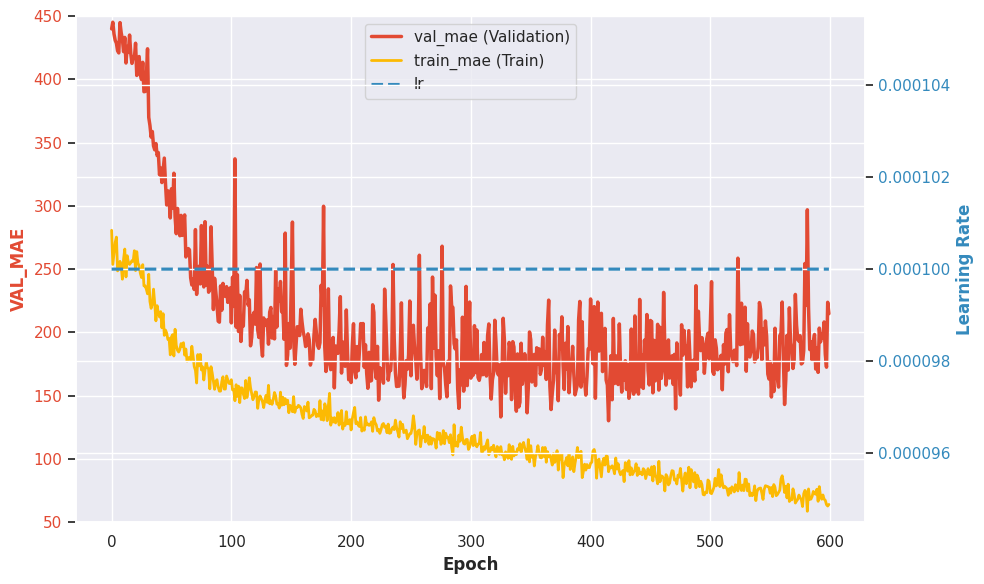

In [12]:

log_data = pd.read_csv('/content/drive/MyDrive/DIP_Crowd_Counting/training_log.csv')
fig = plot_experiment_metrics(
    log_data,
    loss_col='val_mae',
    y_limit=(50, 450),     # Zoom in to ignore early spikes
    theme='darkgrid'
)
plt.show()

## Testing Definition

In [13]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as CM
import numpy as np

# --- 1. Evaluation Function (MAE & MSE) ---
def evaluate_metrics(model, dataloader, device):
    model.eval()
    mae = 0.0
    mse = 0.0
    total_samples = 0

    print("Evaluating model on test set...")

    with torch.no_grad():
        for i, (img, points) in enumerate(dataloader):
            img = img.to(device)
            points = points.to(device)

            # Forward pass
            pred_dmap = model(img)

            # Calculate Counts
            pred_count = pred_dmap.sum().item()
            gt_count = points.shape[1] # Number of points

            # Accumulate Errors
            error = abs(pred_count - gt_count)
            mae += error
            mse += error ** 2
            total_samples += 1

    # Final Metrics
    final_mae = mae / total_samples
    final_mse = (mse / total_samples) ** 0.5 # Root Mean Squared Error

    print(f"\n--- Evaluation Results ---")
    print(f"Total Samples: {total_samples}")
    print(f"MAE: {final_mae:.4f}")
    print(f"MSE (RMSE): {final_mse:.4f}")

    return final_mae, final_mse

# --- 2. Visualization Function ---
def visualize_predictions(model, dataset, device, indices=[0]):
    """
    Visualizes specific samples.
    Left: Input Image with Ground Truth Points (Red Dots).
    Right: Predicted Density Map.
    """
    model.eval()

    for idx in indices:
        # Load sample
        img_tensor, points_tensor = dataset[idx]

        # Prepare for model
        img_input = img_tensor.unsqueeze(0).to(device) # Add batch dim

        # Predict
        with torch.no_grad():
            pred_dmap = model(img_input)

        pred_map_np = pred_dmap.squeeze().cpu().numpy()
        pred_count = pred_map_np.sum()
        gt_count = points_tensor.shape[0]

        # Prepare Image for Display
        # Un-normalize if you normalized in loader, or just permute
        # Assuming simple loading: (C, H, W) -> (H, W, C)
        img_np = img_tensor.permute(1, 2, 0).numpy()

        # Prepare Points for Display
        # Points are scaled down by 4 in the dataset loader (to match output),
        # but for visualization on original image, we might want to scale them back up
        # or just plot them on the image.
        # Note: If MCNN output is 1/4 size, the dataset loader likely divided coords by 4.
        points_np = points_tensor.numpy() * 4

        # --- Plotting ---
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Image + GT Points
        axes[0].imshow(img_np)
        axes[0].scatter(points_np[:, 0], points_np[:, 1], c='r', s=2, label='Heads')
        axes[0].set_title(f"Ground Truth: {gt_count} People")
        axes[0].axis('off')

        # Plot 2: Predicted Density Map
        # Normalize heatmap for better visibility
        if pred_map_np.max() > 0:
            pred_vis = pred_map_np / pred_map_np.max()
        else:
            pred_vis = pred_map_np

        axes[1].imshow(pred_vis, cmap=CM.jet)
        axes[1].set_title(f"Prediction: {pred_count:.2f} People")
        axes[1].axis('off')

        plt.suptitle(f"Sample Index: {idx}", fontsize=16)
        plt.tight_layout()
        plt.show()

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Ensure the model class is defined before running this
# (It must match the class definition you used during training)

def load_and_predict(image_path, model_path, device='cuda'):
    """
    Loads a trained MCNN_DM model and predicts the crowd count and density map.

    Args:
        image_path (str): Path to the input image (.jpg).
        model_path (str): Path to the .pth model checkpoint.
        device (str): 'cuda' or 'cpu'.

    Returns:
        pred_count (float): The estimated number of people.
        pred_map (numpy array): The predicted density map (H, W).
        img_raw (PIL Image): The original image for visualization.
    """

    # 1. Initialize the Architecture
    # We must use the exact same class structure as used during training
    model = MCNN_DM().to(device)

    # 2. Load the Weights
    if os.path.exists(model_path):
        print(f"Loading weights from: {model_path}")
        # 'map_location' ensures we can load a GPU model on CPU if needed
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval() # Set to evaluation mode (freezes BatchNorm, dropout, etc.)
    else:
        raise FileNotFoundError(f"Model path not found: {model_path}")

    # 3. Preprocess the Image
    # Standard Load: (H, W, 3) -> Normalize -> Transpose to (3, H, W) -> Tensor
    img_raw = Image.open(image_path).convert('RGB')
    img_tensor = torch.from_numpy(np.array(img_raw)).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0) # Add batch dim: (1, 3, H, W)
    img_tensor = img_tensor.to(device)

    # 4. Inference
    with torch.no_grad():
        # Forward pass
        pred_map_tensor = model(img_tensor)

        # Calculate Count (Sum of density map)
        pred_count = pred_map_tensor.sum().item()

        # Convert map to numpy for visualization
        # Remove batch and channel dims: (1, 1, H, W) -> (H, W)
        pred_map = pred_map_tensor.squeeze().cpu().numpy()

    return pred_count, pred_map, img_raw

## Testing

In [15]:
# --- 3. Execution Block ---
# Define Paths
test_img_root = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images'
test_gt_root = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth' # Folder with .mat files

# Load Test Dataset
test_dataset = CrowdDatasetAugmented(test_img_root, test_gt_root,
                                     phase='val', gt_downsample=4)
# Note: gt_downsample=4 must match what you used in training
#test_dataset = CrowdDataset(test_img_root, test_gt_root, gt_downsample=4)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=2)



# Load Model (Ensure you point to your saved checkpoint)
# model_path = "mcnn_dm_count_epoch_45.pth" # Example path
# model = MCNN_DM().to(device)
# model.load_state_dict(torch.load(model_path))

# Run Evaluation
evaluate_metrics(model, test_loader, device)

[VAL] Loaded 19 images
Evaluating model on test set...

--- Evaluation Results ---
Total Samples: 19
MAE: 174.1115
MSE (RMSE): 276.8446


(174.11151203356292, 276.84461383466584)

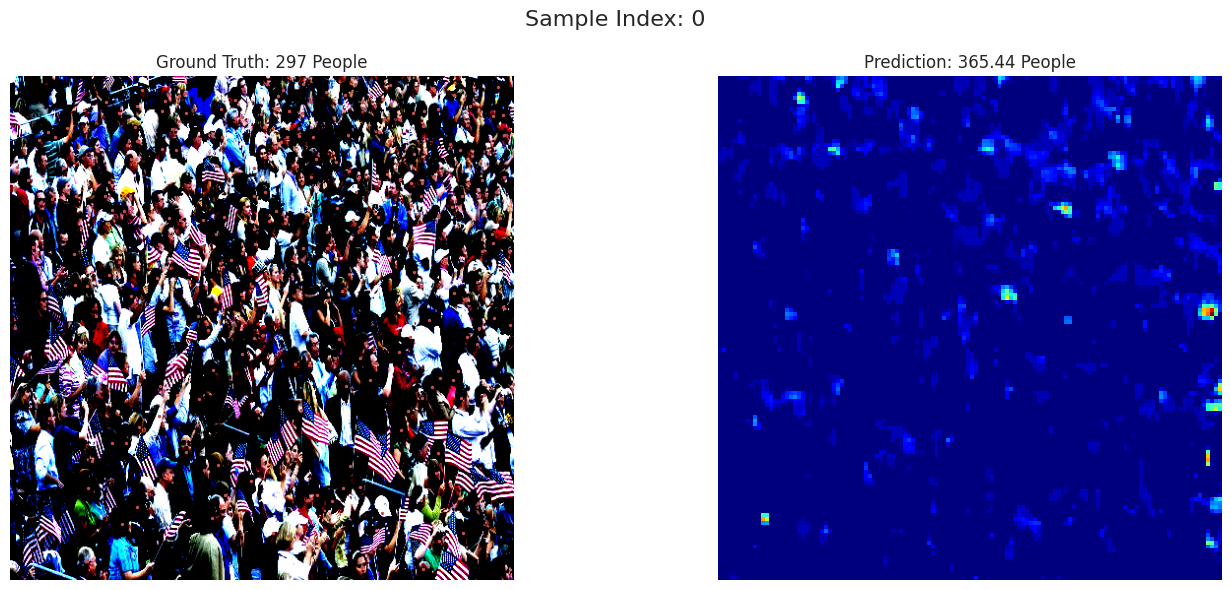

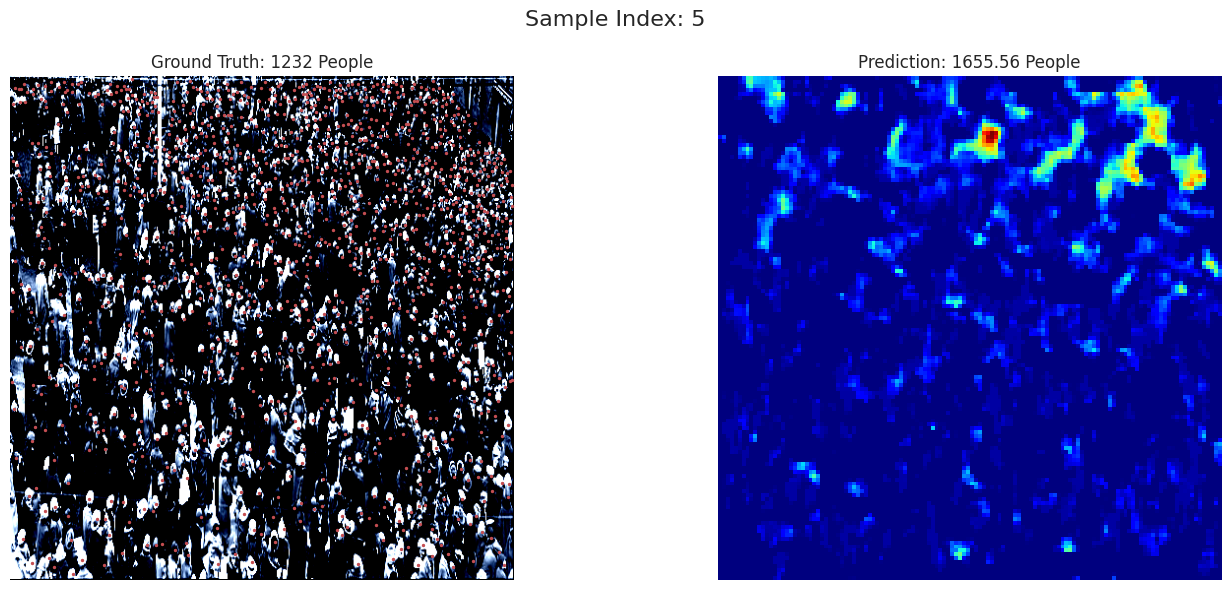

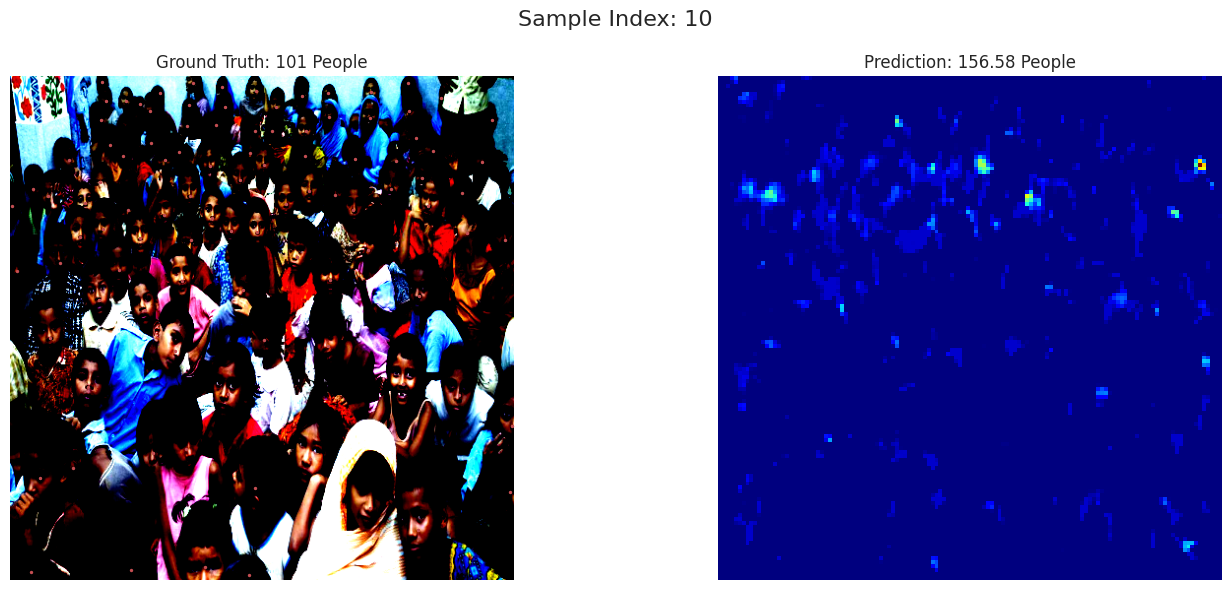

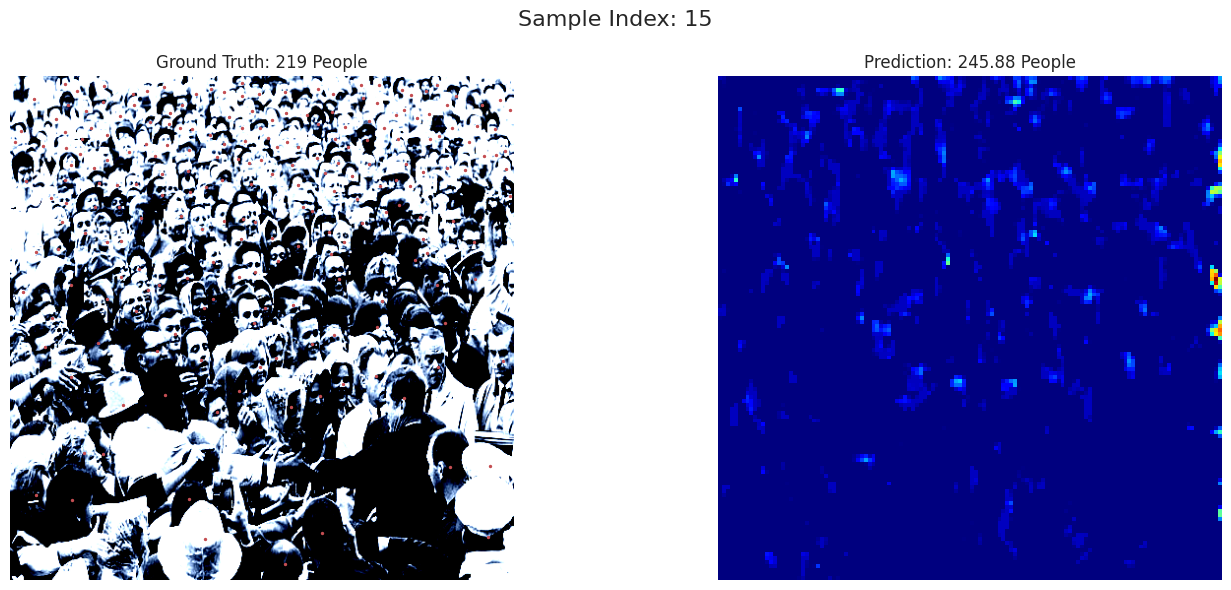

IndexError: list index out of range

In [16]:
# Run Visualization (Sample indices 0, 5, 10)
# Make sure indices exist in your dataset
visualize_predictions(model, test_dataset, device, indices=[0, 5, 10, 15, 20])

## Loading best

In [ ]:
best_path = "/content/drive/MyDrive/DIP_Crowd_Counting/model_Scheduler.pth"
BestModel = MCNN_DM().to(device)
state_dict = torch.load(best_path, map_location=device)
BestModel.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
test_img_root = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images'
test_gt_root = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth' # Folder with .mat files

# Load Test Dataset
# Note: gt_downsample=4 must match what you used in training
test_dataset = CrowdDataset(test_img_root, test_gt_root, gt_downsample=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load Model (Ensure you point to your saved checkpoint)
# model_path = "mcnn_dm_count_epoch_45.pth" # Example path
# model = MCNN_DM().to(device)
# model.load_state_dict(torch.load(model_path))

# Run Evaluation
evaluate_metrics(BestModel, test_loader, device)

Evaluating model on test set...

--- Evaluation Results ---
Total Samples: 182
MAE: 145.3591
MSE (RMSE): 219.6418


(145.35914276458405, 219.64180178359854)